# Momentum broadening anisotropty in the large system limit

In this notebook we compute the momentum broadening anistropy for increasingly large systems while keeping the lattice spacing fixed and set the infrared regulator to zero. Since large lattice sizes are required, we only do this for SU(2).

In [21]:
# Set environment variables 
import os
os.environ["MY_NUMBA_TARGET"] = "cuda"
os.environ["GAUGE_GROUP"] = "su2"
os.environ["PRECISION"] = "double"

# This line is necessary, because cupy otherwise doesn't find
# the cuda installation path. This is probably a configuration
# issue and should be removed on other machines.
os.environ["CUDA_PATH"] = "/usr/local/cuda-9.0"

# Import curraun and other packages
import sys
sys.path.append('..')

import curraun.core as core
import curraun.mv as mv
import curraun.kappa as kappa
import curraun.qhat as qhat
from curraun.energy import Energy
import curraun.initial as initial
initial.DEBUG = False

from curraun.numba_target import use_cuda, use_numba
if use_cuda:
    from numba import cuda

import numpy as np
import pickle, datetime
from tqdm import tqdm

import matplotlib.pyplot as plt

from matplotlib import rc
rc('text', usetex=True)
plt.rcParams["figure.figsize"] = (8, 6)
plt.rcParams.update({'font.size':18})

# define hbar * c in units of GeV * fm
hbarc = 0.197326 

To run our simulations we define a Python function that takes a dictionary of parameters as input and returns a dictionary of observables.

In [2]:
def compute(p):    
    # output dictionary
    output = {}
    output["parameters"] = p.copy()
    output["p_qhat"] = []
    output["p_qhat_data"] = []
    
    # derived parameters
    a = p['L'] / p['N']
    E0 = p['N'] / p['L'] * hbarc
    DT = 1.0 / p['DTS']
    maxt = int(p['TMAX'] / a) * p['DTS']
    
    # event loop
    
    with tqdm(total=p['NE'], file=sys.stdout) as pbar:
        for e in range(p['NE']):
            #print("Initializating ...")
            # initialization
            s = core.Simulation(p['N'], DT, p['G'])
            va = mv.wilson(s, mu=p['MU'] / E0, m=p['M'] / E0, uv=p['UV'] / E0, num_sheets=p['NS'])
            vb = mv.wilson(s, mu=p['MU'] / E0, m=p['M'] / E0, uv=p['UV'] / E0, num_sheets=p['NS'])
            initial.init(s, va, vb)

            # initialize transport computation
            qhat_tforce = qhat.TransportedForce(s)

            # temporary results
            p_qhat = []

            if use_cuda:
                s.copy_to_device()
                qhat_tforce.copy_to_device()

                meminfo = cuda.current_context().get_memory_info()
                #print("CUDA free memory: {:.2f} GB of {:.2f} GB.".format(meminfo[0] / 1024 ** 3, meminfo[1] / 1024 ** 3))

            for t in range(maxt):
                core.evolve_leapfrog(s)

                if t % p['DTS'] == 0:
                    if use_cuda:
                        # Copy data from device to host
                        qhat_tforce.copy_mean_to_host()

                    # unit factors (GeV^2)
                    units = E0 ** 2 / (s.g ** 2)

                    # color factors (for quarks)
                    Nc = core.su.NC
                    f = 2 * s.g ** 2 / (2 * Nc)
                    p_qhat.append(qhat_tforce.p_perp_mean * units * f)

                    if use_cuda:
                        # Copy data back to device
                        qhat_tforce.copy_mean_to_device()

                qhat_tforce.compute()

            pbar.set_description('Event {:3d}'.format(e))
            pbar.update(1)

            p_qhat = np.array(p_qhat)

            output["p_qhat_data"].append(p_qhat)
    
    # perform average over events
    
    # compute mean and standard deviation of accumulated momenta
    output["p_qhat"] = np.mean(np.array(output["p_qhat_data"]), axis=0)
    output["p_qhat_std"] = np.std(np.array(output["p_qhat_data"]), axis=0)
    
    # save all test rest too
    output["p_qhat_data"] = np.array(output["p_qhat_data"]).copy()
    
    # more useful stuff
    output["tau"] = np.linspace(0, p['TMAX'], num=int(p['TMAX'] / a))
    output["E0"] = E0
    
    if use_cuda:
        cuda.current_context().deallocations.clear()
    
    return output

## Taking the limit $\lambda = g^2 \mu L \rightarrow \infty$ while $\gamma = g^2 \mu a = const.$

We rule out that the infrared regulator is causing problems by computing momentum broadening in increasingly larger systems.

In [4]:
def compute_results(gamma, lambdas, fn):
    results = []
    for l in lambdas:
        N = int(2 * np.round(l / gamma / 2)) # enforce even number
        L = l / (g2mu) * hbarc
        a = L / N
        tau = 6.0 / (g2mu / hbarc)

        print("N = {}".format(N))
        print("\gamma = g^2 \mu a = {:3.2f}".format(gamma))
        print("g^2 \mu L = {:3.2f}".format(l))
        print("g^2 mu = {:3.2f} GeV".format(g2mu))
        print("L = {:3.2f} fm".format(L))


        p = {    
            'L':    L,               # transverse size [fm]
            'N':    N,               # lattice size
            'DTS':  16,              # time steps per transverse spacing
            'TMAX': tau,             # max. proper time (tau) [fm/c]

            'G':    g,               # YM coupling constant
            'MU':   mu,              # MV model parameter [GeV]
            'M':    0.,              # IR regulator [GeV]
            'UV':   100000000.0,     # UV regulator [GeV]
            'NS':   20,              # number of color sheets

            'NE':   200,             # number of events
        }

        from time import time
        t1 = time()
        r = compute(p)
        t2 = time()
        print("{:3.2f}s".format(t2-t1))
        r["lambda"] = l

        results.append(r)

    pickle.dump(results, open(fn + ".pickle", "wb"))

In [5]:
# standard values
g = 2.0
mu = 0.25
g2mu = g ** 2 * mu

# compute at various resolutions
gamma = 0.5
lambdas = np.geomspace(50.0, 1600.0, num=11)
Ns = 2 * np.round(lambdas / gamma / 2)
print("\gamma = g^2 \mu a = {:3.4f}".format(gamma))
print("N = {}".format(Ns))
print("\lambda = {}".format(lambdas))
compute_results(gamma, lambdas, "large_system_3_0p5000")

lambdas = np.geomspace(50.0, 800.0, num=9)
gamma = 0.5/2
Ns = 2 * np.round(lambdas / gamma / 2)
print("\gamma = g^2 \mu a = {:3.4f}".format(gamma))
print("N = {}".format(Ns))
print("\lambda = {}".format(lambdas))
compute_results(gamma, lambdas, "large_system_3_0p2500")

lambdas = np.geomspace(50.0, 400.0, num=7)
gamma = 0.5/4
Ns = 2 * np.round(lambdas / gamma / 2)
print("\gamma = g^2 \mu a = {:3.4f}".format(gamma))
print("N = {}".format(Ns))
print("\lambda = {}".format(lambdas))
compute_results(gamma, lambdas, "large_system_3_0p1250")

lambdas = np.geomspace(50.0, 200.0, num=5)
gamma = 0.5/8
Ns = 2 * np.round(lambdas / gamma / 2)
print("\gamma = g^2 \mu a = {:3.4f}".format(gamma))
print("N = {}".format(Ns))
print("\lambda = {}".format(lambdas))
compute_results(gamma, lambdas, "large_system_3_0p0625")

\gamma = g^2 \mu a = 0.5000
N = [ 100.  142.  200.  282.  400.  566.  800. 1132. 1600. 2262. 3200.]
\lambda = [  50.           70.71067812  100.          141.42135624  200.
  282.84271247  400.          565.68542495  800.         1131.3708499
 1600.        ]
N = 100
\gamma = g^2 \mu a = 0.50
g^2 \mu L = 50.00
g^2 mu = 1.00 GeV
L = 9.87 fm
Event 199: 100%|██████████| 200/200 [00:46<00:00,  4.28it/s]
46.69s
N = 142
\gamma = g^2 \mu a = 0.50
g^2 \mu L = 70.71
g^2 mu = 1.00 GeV
L = 13.95 fm
Event 199: 100%|██████████| 200/200 [00:42<00:00,  4.71it/s]
42.51s
N = 200
\gamma = g^2 \mu a = 0.50
g^2 \mu L = 100.00
g^2 mu = 1.00 GeV
L = 19.73 fm
Event 199: 100%|██████████| 200/200 [00:44<00:00,  4.49it/s]
44.52s
N = 282
\gamma = g^2 \mu a = 0.50
g^2 \mu L = 141.42
g^2 mu = 1.00 GeV
L = 27.91 fm
Event 199: 100%|██████████| 200/200 [00:48<00:00,  4.15it/s]
48.22s
N = 400
\gamma = g^2 \mu a = 0.50
g^2 \mu L = 200.00
g^2 mu = 1.00 GeV
L = 39.47 fm
Event 199: 100%|██████████| 200/200 [00:56<00:00,  3

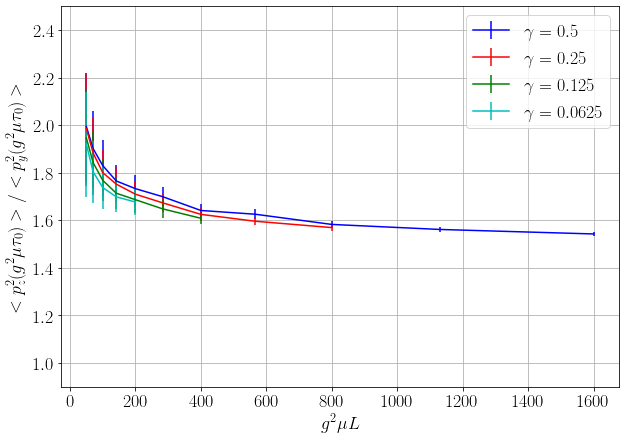

In [29]:
import numpy as np
import pickle, datetime
hbarc = 0.197326 
import matplotlib.pyplot as plt
from matplotlib import rc
rc('text', usetex=True)
plt.rcParams["figure.figsize"] = (10, 7)
plt.rcParams.update({'font.size':18})
from scipy.interpolate import interp1d
fns = ["large_system_3_0p5000", "large_system_3_0p2500", "large_system_3_0p1250", "large_system_3_0p0625"]
colors = ["b", "r", "g", "c"]
for i, fn in enumerate(fns):
    results = pickle.load(open(fn+".pickle", "rb"))
    tau_eval = 6.0  # in (g^2mu)^{-1}        
    plot_data = []
    for r in results:
        tau = r["tau"] / hbarc
        data = r["p_qhat_data"]

        py = data[:, 1:, 1]
        pz = data[:, 1:, 2]
        p_ani = pz / py

        p_ani_mean = np.mean(p_ani, axis=0)
        p_ani_std = np.std(p_ani, axis=0)

        p_ani_mean_int = interp1d(tau[1:], p_ani_mean, 'cubic')
        p_ani_std_int = interp1d(tau[1:], p_ani_std, 'cubic')

        p_ani_mean_value = p_ani_mean_int(tau_eval)
        p_ani_std_value = p_ani_std_int(tau_eval)

        plot_data.append([r["lambda"], p_ani_mean_value, p_ani_std_value])

    plot_data = np.array(plot_data)
    plt.errorbar(x=plot_data[:, 0], y=plot_data[:, 1], yerr=plot_data[:, 2], color=colors[i])

    # save data for pgfplots
    new_fn = fn + "_plot_data.dat"
    np.savetxt(new_fn, plot_data, header="g^2 \mu L, <p^2_z> / <p^2_y> (mean), <p^2_z> / <p^2_y> (std)")
        
plt.grid()
plt.ylim([0.9, 2.5])
plt.xlabel("$g^2 \mu L$")
plt.ylabel("$< p^2_z(g^2  \\mu \\tau_0) > / < p^2_y(g^2  \\mu  \\tau_0) >$")
plt.legend(["$\\gamma = 0.5$", "$\\gamma = 0.25$", "$\\gamma = 0.125$", "$\\gamma = 0.0625$"])
plt.show()